#### Implementation of Momentum Contrast for Unsupervised Visual Representation Learning, to analyse and detect dog emotions.
- Paper : https://arxiv.org/abs/1911.05722
- Code : https://github.com/facebookresearch/moco  

In [1]:
import logging
import os 
import random
from functools import partial

import torch
from PIL import ImageFilter
from torchvision import datasets, transforms
from torchvision.models import resnet 
from tqdm import tqdm 
import numpy as np

from pytorch_metric_learning import losses
from pytorch_metric_learning.utils import logging_presets

logging.getLogger().setLevel(logging.INFO)

device = torch.device("cuda")

##### Augmentation functions taken straight from https://github.com/facebookresearch/moco 
- Two-Crops Transform
- Gaussian Blur

In [2]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]
    
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

##### Dataset creation function.
- Reduces overhead variable accumulation.
- Easy to steal from MoCo :-)

In [3]:
MEAN = [0.47365573, 0.4402452, 0.38663769]
STD = [0.26914782, 0.26083042, 0.2624779]

In [4]:
def create_dataset(batch_size):
    normalize = transforms.Normalize(MEAN, STD)
    
    train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            normalize,
        ]
    )

    train_transform = TwoCropsTransform(train_transform)
    val_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), normalize])
    
    train_dir = 'data/Daniel_Shan_Balico/train/'
    val_dir = 'data/Daniel_Shan_Balico/validation/'
    test_dir = 'data/Daniel_Shan_Balico/test/'
    
    train_dataset = datasets.ImageFolder(
        train_dir , transform=train_transform
    )
    train_dataset_for_eval = datasets.ImageFolder(
        val_dir, transform=val_transform
    )
    val_dataset = datasets.ImageFolder(
        test_dir, transform=val_transform
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    train_loader_for_eval = torch.utils.data.DataLoader(
        train_dataset_for_eval,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    return (
        train_dataset,
        train_dataset_for_eval,
        val_dataset,
        train_loader,
        train_loader_for_eval,
        val_loader,
    )

##### SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension.
- Yanked from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py

In [5]:
class SplitBatchNorm(torch.nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = torch.nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W),
                running_mean_split,
                running_var_split,
                self.weight.repeat(self.num_splits),
                self.bias.repeat(self.num_splits),
                True,
                self.momentum,
                self.eps,
            ).view(N, C, H, W)
            self.running_mean.data.copy_(
                running_mean_split.view(self.num_splits, C).mean(dim=0)
            )
            self.running_var.data.copy_(
                running_var_split.view(self.num_splits, C).mean(dim=0)
            )
            return outcome
        else:
            return torch.nn.functional.batch_norm(
                input,
                self.running_mean,
                self.running_var,
                self.weight,
                self.bias,
                False,
                self.momentum,
                self.eps,
            )

##### Model definition and code for copying params from encQ to encK.

In [6]:
class ModelBase(torch.nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """

    def __init__(self, feature_dim=128, arch="resnet18", bn_splits=8):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = (
            partial(SplitBatchNorm, num_splits=bn_splits)
            if bn_splits > 1
            else torch.nn.BatchNorm2d
        )
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == "conv1":
                module = torch.nn.Conv2d(
                    3, 64, kernel_size=3, stride=1, padding=1, bias=False
                )
            if isinstance(module, torch.nn.MaxPool2d):
                continue
            if isinstance(module, torch.nn.Linear):
                self.net.append(torch.nn.Flatten(1))
            self.net.append(module)

        self.net = torch.nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x


def copy_params(encQ, encK, m=None):
    if m is None:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient
    else:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data = param_k.data * m + param_q.data * (1.0 - m)


def create_encoder():
    model = ModelBase()
    model = torch.nn.DataParallel(model)
    model.to(device)
    return model

##### Evaluation Functions.

In [7]:
def test(net, memory_data_loader, test_data_loader, epoch, knn_k, knn_t, record_keeper):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_num, feature_bank = 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc="Feature extracting"):
            feature = net(data.cuda(non_blocking=True))
            feature = torch.nn.functional.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(
            memory_data_loader.dataset.targets, device=feature_bank.device
        )
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = torch.nn.functional.normalize(feature, dim=1)

            pred_labels = knn_predict(
                feature, feature_bank, feature_labels, classes, knn_k, knn_t
            )

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            acc = total_top1 / total_num * 100
            test_bar.set_description("Test Epoch {}: Acc@1:{:.2f}%".format(epoch, acc))

    record_keeper.update_records(
        {"knn_monitor_accuracy": acc},
        epoch,
        parent_name="accuracy",
    )
    record_keeper.save_records()
    return acc


def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(
        feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices
    )
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(
        feature.size(0) * knn_k, classes, device=sim_labels.device
    )
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(
        dim=-1, index=sim_labels.view(-1, 1), value=1.0
    )
    # weighted score ---> [B, C]
    pred_scores = torch.sum(
        one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1),
        dim=1,
    )

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

##### Training and logging functions.

In [8]:
def update_records(loss, loss_fn, optimizer, record_keeper, global_iteration):
    def optimizer_custom_attr_func(opt):
        return {"lr": opt.param_groups[0]["lr"]}

    record_these = [
        [{"loss": loss.item()}, {"parent_name": "loss_histories"}],
        [{"loss_function": loss_fn}, {"recursive_types": [torch.nn.Module]}],
        [{"optimizer": optimizer}, {"custom_attr_func": optimizer_custom_attr_func}],
    ]
    for record, kwargs in record_these:
        record_keeper.update_records(record, global_iteration, **kwargs)


def save_model(encQ):
    model_folder = "example_saved_models"
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    torch.save(encQ.state_dict(), "{}/encQ_best.pth".format(model_folder))



def batch_shuffle_single_gpu(x):
    """
    Batch shuffle, for making use of BatchNorm.
    """
    # random shuffle index
    idx_shuffle = torch.randperm(x.shape[0]).cuda()

    # index for restoring
    idx_unshuffle = torch.argsort(idx_shuffle)

    return x[idx_shuffle], idx_unshuffle



def batch_unshuffle_single_gpu(x, idx_unshuffle):
    """
    Undo batch shuffle.
    """
    return x[idx_unshuffle]


def create_labels(num_pos_pairs, previous_max_label):
    # create labels that indicate what the positive pairs are
    labels = torch.arange(0, num_pos_pairs)
    labels = torch.cat((labels, labels)).to(device)
    # add an offset so that the labels do not overlap with any labels in the memory queue
    labels += previous_max_label + 1
    # we want to enqueue the output of encK, which is the 2nd half of the batch
    enqueue_mask = torch.zeros(len(labels)).bool()
    enqueue_mask[num_pos_pairs:] = True
    return labels, enqueue_mask


def train(
    encQ,
    encK,
    paramK_momentum,
    loss_fn,
    optimizer,
    train_loader,
    record_keeper,
    global_iteration,
):
    encQ.train()
    pbar = tqdm(train_loader)
    for images, _ in pbar:
        previous_max_label = torch.max(loss_fn.label_memory)
        imgQ = images[0].to(device)
        imgK = images[1].to(device)

        # compute output
        encQ_out = encQ(imgQ)
        with torch.no_grad():  # no gradient to keys
            copy_params(encQ, encK, m=paramK_momentum)
            imgK, idx_unshuffle = batch_shuffle_single_gpu(imgK)
            encK_out = encK(imgK)
            encK_out = batch_unshuffle_single_gpu(encK_out, idx_unshuffle)

        all_enc = torch.cat([encQ_out, encK_out], dim=0)
        labels, enqueue_mask = create_labels(encQ_out.size(0), previous_max_label)
        loss = loss_fn(all_enc, labels, enqueue_mask=enqueue_mask)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("loss=%.5f" % loss.item())
        update_records(
            loss, loss_fn, optimizer, record_keeper, global_iteration["iter"]
        )
        global_iteration["iter"] += 1

##### Start Tensorboard and delete old folders.

In [9]:
!rm -rfv example_logs example_tensorboard example_saved_models
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

removed directory 'example_logs'
removed 'example_tensorboard/events.out.tfevents.1711746348.aarya-ExcaliburOMEN.6807.0'
removed directory 'example_tensorboard'


In [10]:
batch_size = 256
lr = 0.03
paramK_momentum = 0.99
memory_size = 4096
num_epochs = 200
knn_k = 200
knn_t = 0.1

(
    train_dataset,
    train_dataset_for_eval,
    val_dataset,
    train_loader,
    train_loader_for_eval,
    val_loader,
) = create_dataset(batch_size)

encQ = create_encoder()
encK = create_encoder()

# copy params from encQ into encK
copy_params(encQ, encK)

optimizer = torch.optim.SGD(encQ.parameters(), lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

###########################################################
### Set the loss function and the (optional) miner here ###
###########################################################
loss_fn = losses.CrossBatchMemory(
    loss=losses.NTXentLoss(temperature=0.1), embedding_size=128, memory_size=memory_size
)

dataset_dict = {"train": train_dataset_for_eval, "val": val_dataset}
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)

# first check untrained performance
epoch = 0
best_accuracy = test(
    encQ, train_loader_for_eval, val_loader, epoch, knn_k, knn_t, record_keeper
)

global_iteration = {"iter": 0}
for epoch in range(1, num_epochs + 1):
    logging.info("Starting epoch {}".format(epoch))
    train(
        encQ,
        encK,
        paramK_momentum,
        loss_fn,
        optimizer,
        train_loader,
        record_keeper,
        global_iteration,
    )
    curr_accuracy = test(
        encQ, train_loader_for_eval, val_loader, epoch, knn_k, knn_t, record_keeper
    )
    if curr_accuracy > best_accuracy:
        best_accuracy = curr_accuracy
        save_model(encQ)
    scheduler.step()

Test Epoch 0: Acc@1:29.75%: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]
INFO:root:Starting epoch 1
Test Epoch 1: Acc@1:32.75%: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]
INFO:root:Starting epoch 2
Test Epoch 2: Acc@1:34.75%: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]
INFO:root:Starting epoch 3
Test Epoch 3: Acc@1:32.25%: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]
INFO:root:Starting epoch 4
Test Epoch 4: Acc@1:29.50%: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]
INFO:root:Starting epoch 5
Test Epoch 5: Acc@1:30.25%: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]
INFO:root:Starting epoch 6
Test Epoch 6: Acc@1:26.50%: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]
INFO:root:Starting epoch 7
Test Epoch 7: Acc@1:30.00%: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]
INFO:root:Starting epoch 8
Test Epoch 8: Acc@1:29.50%: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
INFO:root:Starting epoch 9
Test Epoch 9: Acc@1:29.00%: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]
INFO:root:Startin

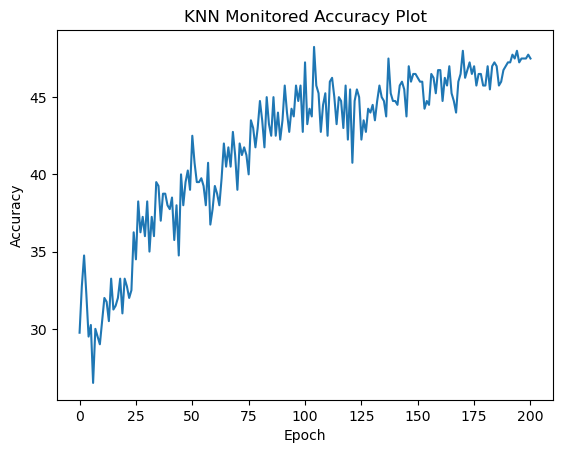

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
accuracy_df = pd.read_csv('example_logs/accuracy.csv')
accuracy = accuracy_df['knn_monitor_accuracy']
plt.plot(accuracy)

plt.title('KNN Monitored Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

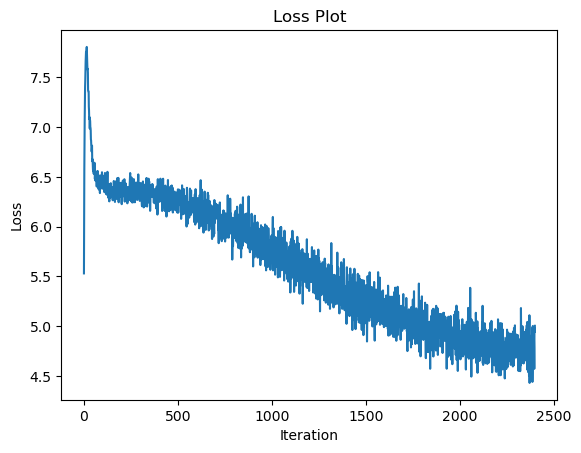

In [15]:
loss_df = pd.read_csv('example_logs/loss_histories.csv')
loss = loss_df['loss']
plt.plot(loss)

plt.title('Loss Plot')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()